## Popular Data Science Questions
#### (exploring the family of Stack Exchange Websites)

## === Prelude ===

#### The Stack Exchange Websites welcomes every type of questions related to the subject in matter. For example, the Stack Exchange Website related to Data Science is populated with questions and queries related to the subject of Data Science. They vary from how to plot a graph, to questions related to a programming language such as Python.
#### The range of subdivisions on the Data Science Stack Exchange (DSSE) go from popular libraries like Pandas, Keras, Tensorflow to the programming language Python, passing trough Statistics, Predictive-modeling, Time-series, regression, etc. 
#### Apart from all this information, we can also explore all the Questions that were made in the website, and some data related to them, such as how many answers each question had, votes, views.
#### Maybe we could take the approach of using as a proxy the most popular - most viewed, most answered, and most voted - questions/tags as one of the hottest topics for Data Science enthusiasts.

#### After drilling down into the several tables available in the Stack Exchange Data Explorer (SEDE) - https://data.stackexchange.com/datascience/query/new - we found that the most valuable ones for our strategy would be both the *Posts* as the *Tags*. Combining both tables we can get a good insight into the most popular Data Science topics, the ones with most comments, favorites, and most answered ones, and combine that data with the *Tags* being more frequently used. 

#### After running the following query: 
``` mysql
SELECT PostTypeId as type_of_posts, COUNT(*) as nº_of_posts
  FROM Posts
 GROUP BY PostTypeId
   ORDER BY nº_of_posts DESC;
```
### Findings:

#### - One could check that the two most numerous post types are the 2 and the 1, *Answer* and *Question*. Let's now focus on the Questions side. 
### Now, pulling the data for the *Posts* related only to the recent Questions - from 2019 onwards:
``` mysql
SELECT Id, 
       PostTypeId, 
       CreationDate, 
       Score, 
       ViewCount, 
       Tags, 
       AnswerCount, 
       FavoriteCount
  FROM Posts
 WHERE PostTypeId = 1 AND CreationDate >= '2019-01-01'
ORDER BY CreationDate;
```


### Now lets read into the file created from the query above:

In [1]:
# Importing Libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
%matplotlib inline

# Reading into the file:
posts = pd.read_csv('2019_questions.csv', parse_dates=['CreationDate'])

# Creating a sample of five rows from the newly created posts DataFrame:
posts.sample(5)


,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
6631,63882,2019-11-27 19:06:27,1,9,<nlp><reinforcement-learning><chatbot>,0,NaN
3139,48531,2019-04-03 15:16:24,45,7278,<data-wrangling>,9,16.0
1076,45807,2019-02-19 12:08:37,2,65,<python><time-series><machine-learning-model><...,1,1.0
4981,62373,2019-10-29 17:40:53,0,9,<deep-learning><lstm><word2vec><word-embedding...,0,NaN
6768,64487,2019-12-09 15:06:25,0,26,<clustering><feature-engineering><features>,0,NaN


In [2]:
# Checking the structure of the different cols in the Dataframe:
posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    1407 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 483.5+ KB


In [3]:
# Searching for null values in the FavoriteCount column:
posts['FavoriteCount'].value_counts(dropna=False)

NaN      7432
 1.0      953
 2.0      205
 0.0      175
 3.0       43
 4.0       12
 5.0        8
 6.0        4
 7.0        4
 11.0       1
 8.0        1
 16.0       1
Name: FavoriteCount, dtype: int64

In [4]:
posts['Tags'].value_counts()[:15]

<machine-learning>             118
<python><pandas>                58
<python>                        55
<r>                             38
<tensorflow>                    36
<nlp>                           35
<neural-network>                35
<reinforcement-learning>        32
<deep-learning>                 29
<keras>                         29
<time-series>                   26
<keras><tensorflow>             24
<machine-learning><python>      23
<classification>                23
<python><pandas><dataframe>     22
Name: Tags, dtype: int64

### Findings:

#### - We have a tremendous amount of missing (NaN) datapoints in our posts Dataframe, mainly in our *FavoriteCount* column. Where 7432 datapoints, out of 8839, are NaN's. Apart from this particular col we do not have any other missing values in our Dataframe.
####  - From a quick search we found out that this missing values might correspond to *Questions* that have never been favorited, hence felt into the *forgotten* category. And the difference between these and the 0.0 values, in the *FavoriteCount* column, is that the last were once favorited *Questions* that lost their favorited pedigree to the extent of 0.  - https://meta.stackexchange.com/questions/327680/why-do-some-questions-have-a-favorite-count-of-0-while-others-have-none
#### - We have two solutions to fix  this missing values in our Dataframe. The first solution would be to simply erase the rows, the second solution would be to assign to all the rows that have missing values, and based on our findings, the value of 0, implying that these rows have zero favorite votes. Due to the size of the missing values in our Dataframe we would suggest to opt for the second solution, thus not losing a lot of data.
#### - Regarding our *Tags* col we could, in order to favour the analysis, and to smooth the results, further group the column, or we could also treat each group of tags as an individual tag. But first of all we should separate each tag properly, i e, with a comma (,). 

## Cleaning the Dataset Part I

### First let's fill in the missing values in our *FavoriteCount* column with zeros (0). And then changing the col type from a float to a integer one:


In [5]:
# Resorting to the fillna method:
posts['FavoriteCount'] = posts['FavoriteCount'].fillna(0)

# Validating the results:
posts.sample(5)

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
4585,61862,2019-10-17 10:49:44,0,11,<classification><class-imbalance><weka>,0,0.0
7419,64945,2019-12-16 23:22:28,1,45,<classification><clustering><k-means>,1,0.0
3846,49365,2019-04-16 03:37:57,0,12,<statistics><correlation><probability><distrib...,0,0.0
4939,51482,2019-05-06 09:02:09,1,91,<tensorflow><rnn>,0,0.0
7805,54526,2019-06-26 08:45:30,0,18,<machine-learning><neural-network><generative-...,0,0.0


In [6]:
# Changing the FavoriteCount col type:
posts['FavoriteCount'] = posts['FavoriteCount'].astype(int)
posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    8839 non-null int64
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 483.5+ KB


### Its time now to clean the *Tags* column and separate each different tag by a  comma (,):

In [7]:
# Resorting to the str.replace method in order to clean the Tags col:
posts['Tags'] = posts['Tags'].str.replace('><', ',').str.replace('<', '').str.replace('>', '').copy()
posts.head()

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,44419,2019-01-23 09:21:13,1,21,"machine-learning,data-mining",0,0
1,44420,2019-01-23 09:34:01,0,25,"machine-learning,regression,linear-regression,...",0,0
2,44423,2019-01-23 09:58:41,2,1651,"python,time-series,forecast,forecasting",0,0
3,44427,2019-01-23 10:57:09,0,55,"machine-learning,scikit-learn,pca",1,0
4,44428,2019-01-23 11:02:15,0,19,"dataset,bigdata,data,speech-to-text",0,0


### Now lets check, from the different *Tags*, which are the most popular ones, using two distinct popularity proxies: first we will count the number of times that each Tag was used, and come up with a top5. Then we will use the parameter *ViewCount* to grasp, among the top5 most used *Tags*, which one of the five was most viewed.

### We are going to calculate the number of times each Tag was used, first by spliting on the commas (,) each individual Tag from their counterparts, then by stacking the full Dataframe that resulted from that, and finally counting the number of times that each different Tag was used:

In [8]:
# Splitting the Tags column and counting how many times each tag appears:
tags_count = posts['Tags'].str.split(',', expand=True).stack().value_counts()

# Defining a top5 tag per number of appearance: 
tags_top5 = tags_count.head(5)
print(tags_top5)

machine-learning    2693
python              1814
deep-learning       1220
neural-network      1055
keras                935
dtype: int64


## Exploring the Numbers Part I

#### Plotting the above results:

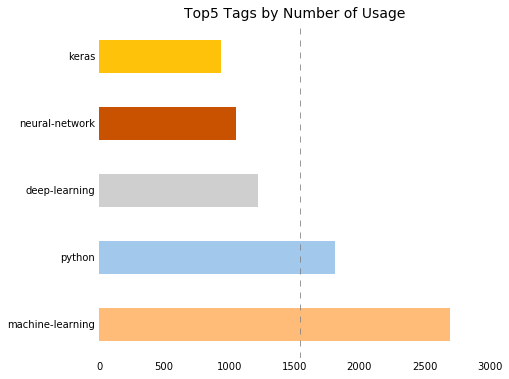

In [9]:
# Plotting the tags_top5 DataFrame in an horizontal bar graph:
tags_top5_graph = tags_top5.plot.barh(
                    edgecolor='none',
                    color = [(255/255,188/255,121/255),
                            (162/255,200/255, 236/255),
                            (207/255,207/255,207/255),
                            (200/255,82/255,0/255),
                            (255/255,194/255,10/255)],
                    figsize=(7,6))

# Enhancing plot aesthetics:
# Removing all the 4 spines with a for loop from our graph figure:
for key, spine in tags_top5_graph.spines.items():
    spine.set_visible(False)
    
# Removing the ticks:
tags_top5_graph.tick_params(
                            bottom='off', top='off', left='off', right='off')
# Setting a graph title:
tags_top5_graph.set_title('Top5 Tags by Number of Usage', fontsize=14)

# Setting an average graph line:
tags_top5_graph.axvline(tags_top5.mean(),
                       alpha=.8, linestyle='--', color='grey')

# Displaying the graph:
plt.show()


In [10]:
posts[posts['Tags'].str.contains('machine-learning')]['ViewCount'].sum()

398666

### Now lets check, from the top5 *Tags* calculated above, which one is the most viewed. We will do so using the str.contains() method combined with a mask to filter only the top5 *Tags* in our *posts* Dataframe, and then, concentrating on the *ViewCount* col, adding all the times each tag was viewed:

In [11]:
# Creating the tags_top5_views DataFrame(DF):
tags_top5_views = pd.DataFrame(
                                columns=tags_top5.index, 
                                index=['Total Views'])


for r in range(0,5):
    df = tags_top5
    n_views = posts[posts['Tags'].str.contains(df.index[r])]['ViewCount'].sum()
    print(str(df.index[r]) + '__total-views:',n_views)
    
# Filling in the tags_top5_views DF with the name of the columns and respective
# number of views:
    col = tags_top5_views.columns[r]
    tags_top5_views[col] = [n_views]


machine-learning__total-views: 398666
python__total-views: 541691
deep-learning__total-views: 233628
neural-network__total-views: 185367
keras__total-views: 269051


#### Plotting the above results: 

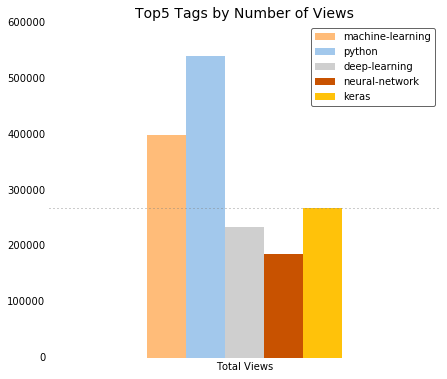

In [12]:
# Plotting the tags_top5_views DataFrame in a bar graph:
tags_top5_views_graph = tags_top5_views.plot.bar(edgecolor='none',
                                            color = [(255/255,188/255,121/255),
                            (162/255,200/255, 236/255),
                            (207/255,207/255,207/255),
                            (200/255,82/255,0/255),
                            (255/255,194/255,10/255)], figsize=(7,6))

# Enhancing plot aesthetics: 
# Removing all the 4 spines with a for loop from our graph figure:
for key, spine in tags_top5_views_graph.spines.items():
    spine.set_visible(False)
    
# Removing the ticks from the graph:
tags_top5_views_graph.tick_params(
                                  top ='off',
                                  bottom = 'off',
                                  right = 'off',
                                  left = 'off')
   
# Setting up a legend box for our bar graph:    
tags_top5_views_graph.legend(
    loc='upper right', 
    labels=(tags_top5_views.columns), 
    ncol=1, fancybox=True, framealpha=.6,
    prop={'size': 10})

# Rotating the xtick labels:
plt.xticks(rotation='horizontal')

# Setting a graph title:
tags_top5_views_graph.set_title('Top5 Tags by Number of Views', fontsize=14)

# Setting an average graph line:
tags_top5_views_graph.axhline(n_views.mean(),
                             color='grey',
                             alpha=.8,
                             linestyle=':')

plt.show()

### Findings:
#### - It is clear that among our top5 *Tags* there are two that stand out: Machine-Learning (ML) and Python (Py). Not only are these two *Tags* the most used (ML-2693 times; Py-1814 times) but also the most viewed ones (Py-541691 views; ML-398666 views).
#### - We've got two pretty good potential candidates for our assignment, and two compimentlary ones that can even be combined into a major one: Python and Machine-Learning.

In [13]:
# Checking how often the Tags python and tensorflow appear together in the Dataset:
posts[posts['Tags'].apply(
    lambda tags: True if 'python' and 'tensorflow' in tags else False)].shape[0]

584

### Findings:

#### - The use of pairs or an even bigger group of tags grouped together, along our Dataframe, is probably related to their intrinsic relationship, dependency in one another, and common usage. For example, *keras* is a library used 'inside' Pythons ecosystem, such as *scikit-learn*. *Tensorflow* is used with *Python* through a dedicated API. And all these tools, apart from being used along with *Python*, are being used to 'train'/'teach'/'feed' algorithms, or in other words, to do *machine-learning*/*deep-learning*. So now we can understand why so many of these tags are grouped together in our Dataframe.

### Prior to summarizing our findings let's dig deeper into Deep Learning and check whether or not this trend as come to stay.

In [14]:
# Reading into the file:
all_questions = pd.read_csv('all_questions.csv', parse_dates=['CreationDate'])
all_questions.head()

,Id,CreationDate,Tags
0,45416,2019-02-12 00:36:29,<python><keras><tensorflow><cnn><probability>
1,45418,2019-02-12 00:50:39,<neural-network>
2,45422,2019-02-12 04:40:51,<python><ibm-watson><chatbot>
3,45426,2019-02-12 04:51:49,<keras>
4,45427,2019-02-12 05:08:24,<r><predictive-modeling><machine-learning-mode...


## Cleaning the Dataset Part II

### Doing the same process as we've done above, and cleaning the Tags column separating each different tag by a comma (,):¶

In [15]:
# Resorting to the str.replace method in order to clean the Tags col:
all_questions['Tags'] = all_questions['Tags'].str.replace('><', ',').str.replace('<', '').str.replace('>', '').copy()
all_questions.sample(5)

,Id,CreationDate,Tags
15969,63150,2019-11-14 11:14:15,"deep-learning,keras,tensorflow,reinforcement-l..."
4602,47449,2019-03-17 04:26:00,reinforcement-learning
6382,39977,2018-10-20 16:18:46,"python,pandas,dataframe"
10566,51102,2019-04-29 10:20:17,"machine-learning,classification"
14324,10457,2016-03-01 02:46:31,"machine-learning,svm,visualization,performance..."


### We will define a cut-off in terms of what we consider a *deep-learning* question or not, and we are only assuming questions related to the *deep-learning* topic as question with one, and one only *deep-learning* Tag in it.  

In [16]:
# Defining what we consider to be a deep-learning Tag:
deep_learning = all_questions[all_questions['Tags'] == 'deep-learning']

# Sorting the Dataframe per Date:
deep_learning = deep_learning.sort_values(by='CreationDate')
deep_learning.head()

,Id,CreationDate,Tags
5514,5375,2015-03-23 17:36:03,deep-learning
8039,6643,2015-07-31 08:21:49,deep-learning
16750,11591,2016-05-04 18:17:38,deep-learning
2852,15984,2016-12-29 03:35:35,deep-learning
3513,16276,2017-01-12 11:28:45,deep-learning


In [17]:
deep_learning.tail()

,Id,CreationDate,Tags
14682,62769,2019-11-06 12:48:16,deep-learning
15307,62896,2019-11-08 20:56:55,deep-learning
18065,64103,2019-12-02 16:10:37,deep-learning
18785,64645,2019-12-11 12:32:05,deep-learning
20660,66004,2020-01-07 06:54:06,deep-learning


### Findings:
#### - It's clear that the range of our *deep-learning* sample varies from 2015 and 2020. Although for 2020 the size of the sample is too small, only contaning one month. 

### Now it is time to group together our *deep-learning* data, based on its year:

In [18]:
deep_learning_grp = deep_learning.groupby(
                    deep_learning.CreationDate.dt.year).sum().sort_values(by='Id')
deep_learning_grp.head(10)

,Id
CreationDate,
2015,12018
2016,27575
2020,66004
2017,265854
2018,562010
2019,1625975


### Applying the same process as above, to the *all_questions* Dataframe:

In [19]:
all_questions_grp = all_questions.groupby(
                    all_questions.CreationDate.dt.year).sum()
all_questions_grp.head(10)

,Id
CreationDate,
2014,774987
2015,8241798
2016,27199660
2017,62341989
2018,189044640
2019,482278000
2020,30388658


### Lets now merge the two Dataframes into one, for the sake of our analysis, and proceed with some comparisons and conclusions:

In [20]:
# Merging the 2 Datasets:
deep_all = pd.merge(all_questions_grp, deep_learning_grp, how='left', 
                    left_index=True, right_index=True)

# Renaming the cols:
deep_all = deep_all.rename(
                        columns={'Id_x':'all_questions','Id_y':'deep_learning' })
deep_all.head(10)

,all_questions,deep_learning
CreationDate,,
2014,774987,NaN
2015,8241798,12018.0
2016,27199660,27575.0
2017,62341989,265854.0
2018,189044640,562010.0
2019,482278000,1625975.0
2020,30388658,66004.0


### In order to adjust both samples and to make the comparison cleaner we will drop rows 2014, since there is no data for the *deep-learning* Tag for this period, and also the row 2020, due to the lack of sufficient data for these year in particular. This way our comparisons are more robust and consistent:

In [21]:
# Dropping the 2014 and 2020 cols:
deep_all = deep_all.drop([2014, 2020], axis=0)
deep_all.head(10)

,all_questions,deep_learning
CreationDate,,
2015,8241798,12018.0
2016,27199660,27575.0
2017,62341989,265854.0
2018,189044640,562010.0
2019,482278000,1625975.0


## Exploring the Numbers Part II

### Let us now make another test, and compare the number of *deep_learning* *Tags* against all the questions made in the Stack Exchange website, in order to demonstrate and validate its growth in terms of all the questions ever made. Making a kind of common-size analysis:

In [22]:
# Calculating the percentage of deep learning Tags among all the questions:
deep_all['%_deep_learning'] = (deep_all[
    'deep_learning']/deep_all['all_questions'])*100
deep_all['date'] = deep_all.index

# Dropping index (other way could be df.index.name=None): 
deep_all.reset_index(drop=True, inplace=True)

# Reorganizing the columns order:
deep_all = deep_all[['date', 'all_questions', 'deep_learning', '%_deep_learning']]
deep_all.head(10)

,date,all_questions,deep_learning,%_deep_learning
0,2015,8241798,12018.0,0.145818
1,2016,27199660,27575.0,0.101380
2,2017,62341989,265854.0,0.426445
3,2018,189044640,562010.0,0.297290
4,2019,482278000,1625975.0,0.337145


### Findings:
#### - From a first glimpse we can observe an upward trend along the years, in the use of the *deep_learning* *Tags*. In 2015 their number were around 12000, as in 2019 these numbers climbed to figures around 1600000. This is an impressive growth. 

#### - In terms of their percentage, among all questions made in the Stack Exchange website, the growth trend is also there, albeit not so strong and not so linear. Now let's visualize it.

#### Plotting the results:

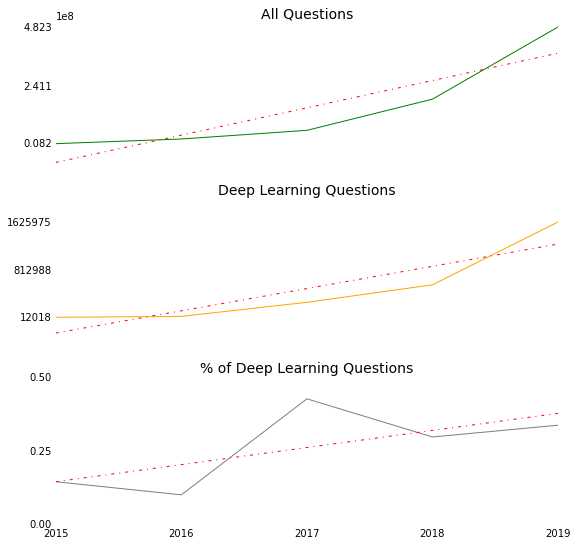

In [23]:
fig = plt.figure(figsize=(9,9))
ax_spines = ['right', 'left', 'bottom', 'top']

ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)
x = deep_all['date']
xi = list(range(len(x)))

plt.xlabel=('x')
plt.xticks(xi, x)

# Setting a trend line:
trend_all = np.polyfit(x, deep_all['all_questions'], 1)
p_all = np.poly1d(trend_all)

ax1.plot(deep_all['all_questions'], color='green')
ax1.plot(p_all(x), 'r-.')

# Setting the yticks for ax1:
ax1.set_yticks([deep_all['all_questions'].min(), deep_all['all_questions'].max()/2,
     deep_all['all_questions'].max()])

# Setting a trend line:
trend_deep = np.polyfit(x, deep_all['deep_learning'], 1)
p_deep = np.poly1d(trend_deep)

ax2.plot(deep_all['deep_learning'], color = 'orange')
ax2.plot(p_deep(x), 'r-.')

# Setting the yticks for ax2:
ax2.set_yticks([deep_all['deep_learning'].min(), deep_all['deep_learning'].max()/2,
     deep_all['deep_learning'].max()])

# Setting a trend line:
trend_deep_perc = np.polyfit(x, deep_all['%_deep_learning'], 1)
p_deep_perc = np.poly1d(trend_deep_perc)

ax3.plot(deep_all['%_deep_learning'], color='grey')
ax3.plot(p_deep_perc(x), 'r-.')

# Setting the yticks for ax3:
ax3.set_yticks([0, 0.25, 0.5])

# Giving each graph a title:
ax1.set_title('All Questions', fontsize=14)
ax2.set_title('Deep Learning Questions', fontsize=14)
ax3.set_title('% of Deep Learning Questions', fontsize=14)

# Enhancing plot aesthetics: 
# Removing the ticks from the graph:
for i in range(3):
    ax = fig.add_subplot(3,1,i+1)
    ax.tick_params(
                                  top ='off',
                                  bottom = 'off',
                                  right = 'off',
                                  left = 'off')
    
# Removing all the 4 spines with a for loop from our graph figure:
    for i in range(0,4):
        ax.spines[ax_spines[i]].set_visible(False)

# Removing unnecessary x labels:
for i in range(1,3):
    ax = fig.add_subplot(3,1,i)
    ax.tick_params(labelbottom=False)

plt.show()

### Findings:

#### - It is clear that we can actually see, along the years, a clear upward trend in the interest shown for the Deep Learning subject. Although being true, this statement is not so strong when we analyze the number of Deep Learning questions, compared to the Total Questions (*All Questions*).  We still conclude that there is a growth, from year 2015 to 2019, in Deep Learning interest, but the linearity of that growth lacks strongness.
#### - To sum it up, it's fair to say that Deep Learning is a subject that deserves our attention due to the traction it gained along the 5 years in our analysis. 

### What if we could use another popularity assessment metric apart from the ones we've been using? What if we used, for example, *FavoriteCount*, or *Scores*, what would be our results? Lets find out.

### As a complementary analysis we are now going to assess which of the different Data Science *themes* are the most popular ones, but resorting to a slightly different approach. First we are going to choose the *Scores* metric but with a bit of a twist.
### We will focus on the top 10 most scored Tags. This will be the cutoff of our analysis.
### After having our top 10 we will then calculate the *ratio* between the total score of each of those Tags and the number of times that those very same Tags were used in the Stack Exchange.
### We will then repeat the process for the metric *FavoriteCount* and compare both of them. 

In [24]:
# Creating our top_10_scores DF.Based on which of the Tags used got the more score.
top_scores = posts[[
    'Score', 'Tags']].groupby(
                            'Tags').agg({
                                        'Score':'sum'
                                        }).sort_values(
                                        by='Score',ascending=False).reset_index()
top_10_scores = top_scores.head(10)
print(top_10_scores)

                              Tags  Score
0                 machine-learning     83
1   machine-learning,deep-learning     48
2                   data-wrangling     45
3                    python,pandas     44
4           reinforcement-learning     42
5  machine-learning,classification     36
6                              nlp     33
7                   neural-network     29
8                            keras     27
9         machine-learning,xgboost     25


In [25]:
# Chaining together the unique Tags of our top_10_scores DF, and creating a list 
# of their own:
top_10_tags_s = top_10_scores['Tags'].str.split(',')
unique_top10_tags = np.unique(list(chain(*top_10_tags_s)))
print(unique_top10_tags)

['classification' 'data-wrangling' 'deep-learning' 'keras'
 'machine-learning' 'neural-network' 'nlp' 'pandas' 'python'
 'reinforcement-learning' 'xgboost']


In [26]:
# Creating our top10_score_tags_ratio DF:
top10_score_tag_ratio = []

for tags in unique_top10_tags:
    top10_score_tag_ratio.append(
    {
    'Tags': tags,
    'Score-Tag_ratio': round((top_scores[top_scores['Tags'].str.contains(tags)]['Score'].sum())\
    /(top_scores[top_scores['Tags'].str.contains(tags)].shape[0]),3) 
    }
        )

top10_score_tag_ratio = pd.DataFrame(top10_score_tag_ratio)

# Changing the col's order, sorting the values by their ratio and droping the index:
top10_score_tag_ratio = top10_score_tag_ratio.loc[
                        :,['Tags', 'Score-Tag_ratio']].sort_values(
                        by='Score-Tag_ratio', ascending=False).\
                        reset_index(drop=True)
    
top10_score_tag_ratio.head(10)

,Tags,Score-Tag_ratio
0,data-wrangling,4.929
1,reinforcement-learning,1.357
2,pandas,1.348
3,xgboost,1.331
4,neural-network,1.260
5,machine-learning,1.239
6,nlp,1.233
7,deep-learning,1.174
8,classification,1.165
9,keras,1.146


### Repeating the same process, but this time for the metric *FavoriteCount* 

In [27]:
# Creating our top10_favoritecount DF.Based on which of the Tags used got the 
# more counts as favorite:
top_favoritecount = posts[[
    'FavoriteCount', 'Tags']].groupby(
                            'Tags').agg({
                                        'FavoriteCount':'sum'
                                        }).sort_values(
                                        by='FavoriteCount',ascending=False).reset_index()

top10_favoritecount = top_favoritecount.head(10)
print(top_10_scores)

                              Tags  Score
0                 machine-learning     83
1   machine-learning,deep-learning     48
2                   data-wrangling     45
3                    python,pandas     44
4           reinforcement-learning     42
5  machine-learning,classification     36
6                              nlp     33
7                   neural-network     29
8                            keras     27
9         machine-learning,xgboost     25


In [28]:
# Chaining together the unique Tags of our top10_favoritecount DF, and creating a 
# list of their own:
top10_favoritecount_tags = top10_favoritecount['Tags'].str.split(',')
unique_top10_favoritecount_tags = np.unique(list(chain(*top10_favoritecount_tags)))

print(unique_top10_favoritecount_tags)

['activation-function' 'bert' 'classification' 'data-product'
 'data-wrangling' 'deep-learning' 'gradient-descent' 'keras' 'lstm'
 'machine-learning' 'mathematics' 'neural-network' 'optimization' 'python']


In [29]:
# Creating our top10_favoritecount_ratio DF:
top10_favoritecount_tag_ratio = []

for tags in unique_top10_favoritecount_tags:
    top10_favoritecount_tag_ratio.append(
    {
    'Tags': tags,
    'FavoriteCount-Tag_ratio': 
    round((top_favoritecount[top_favoritecount['Tags'].str.contains(tags)]['FavoriteCount'].sum())\
    /(top_favoritecount[top_favoritecount['Tags'].str.contains(tags)].shape[0]),3) 
    }
        )

top10_favoritecount_tag_ratio = pd.DataFrame(top10_favoritecount_tag_ratio)

# Changing the col's order, sorting the values by their ratio, and droping the index:
top10_favoritecount_tag_ratio = top10_favoritecount_tag_ratio.loc[
                        :,['Tags', 'FavoriteCount-Tag_ratio']].sort_values(
                        by='FavoriteCount-Tag_ratio', ascending=False).\
                        reset_index(drop=True)
    
top10_favoritecount_tag_ratio.head(10)

,Tags,FavoriteCount-Tag_ratio
0,data-product,2.333
1,data-wrangling,1.571
2,mathematics,0.875
3,bert,0.667
4,gradient-descent,0.452
5,activation-function,0.400
6,neural-network,0.280
7,machine-learning,0.279
8,deep-learning,0.277
9,classification,0.276


### Now that we have both our *top10_score_tag_ratio* and our *top10_favoritecount_tag_ratio* Dataframes, we will plot both and compare the different results obtained between each other. And because we also want to compare these results with the previous ones - *Top5 Tags by Number of Usage* and *Top5 Tags by Number of Views* - we need, for the sake of comparing apples to apples, to plot only our top5 results for both the *top10_score_tag_ratio* and *top10_favoritecount_tag_ratio* Dataframes.

In [30]:
plt.rcParams['patch.edgecolor'] = 'white'

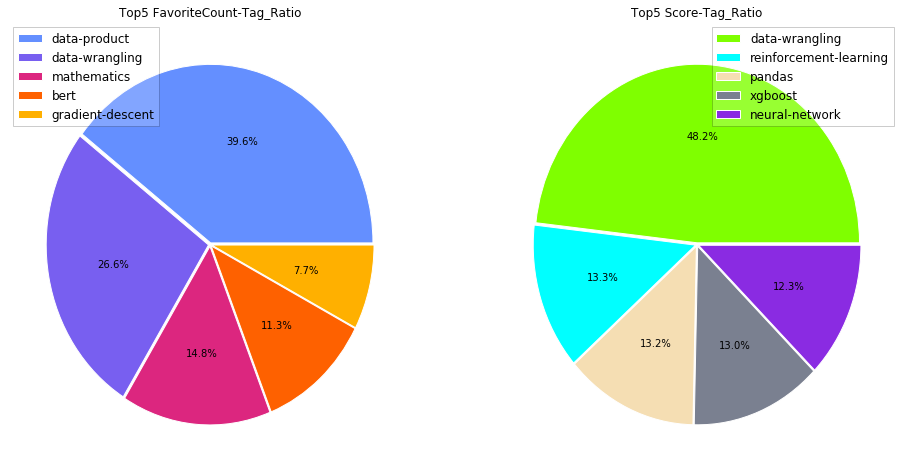

,Tags,FavoriteCount-Tag_ratio,Tags,Score-Tag_ratio
0,data-product,2.333,data-wrangling,4.929
1,data-wrangling,1.571,reinforcement-learning,1.357
2,mathematics,0.875,pandas,1.348
3,bert,0.667,xgboost,1.331
4,gradient-descent,0.452,neural-network,1.260


In [31]:
# Creating a figure with two subplots, and defining the figure size:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

# Attributing our data to 2 different variables. Each for a different subplot:
data1 = top10_favoritecount_tag_ratio[:5]['FavoriteCount-Tag_ratio']
data2 = top10_score_tag_ratio[:5]['Score-Tag_ratio']

# Plotting each different Pie chart in a separate subplot (ax1 and ax2).
# Plotting ax1:
ax1.pie(data1, 
        colors = [(100/255,143/255,255/255),
                 (120/255,95/255,240/255),
                 (220/255,38/255,127/255),
                 (254/255,97/255,0/255),
                 (255/255,176/255,0/255)],
        explode = [0.01, 0.01, 0.01, 0.01, 0.01],
        autopct = '%.1f%%')

# Setting the title for the ax1 Pie chart:
ax1.set_title('Top5 FavoriteCount-Tag_Ratio')

# Setting and configurating the legend for the ax1 Pie chart:
ax1.legend(top10_favoritecount_tag_ratio[:5]['Tags'], 
           loc='upper left', framealpha=0.2)

# Plotting ax2:
ax2.pie(data2,
        colors = [(127/255,255/255,0/255),
                 (0/255,255/255,255/255),
                 (245/255,222/255,179/255),
                 (122/255,128/255,144/255),
                 (138/255,43/255,226/255)],
        explode = [0.01, 0.01, 0.01, 0.01, 0.01],
        autopct = '%.1f%%')

# Setting the title for the ax1 Pie chart:
ax2.set_title('Top5 Score-Tag_Ratio')

# Setting and configurating the legend for the ax1 Pie chart:
ax2.legend(top10_score_tag_ratio[:5]['Tags'], 
           loc='upper right', framealpha=0.2)

# Removing the edgecolor black from all the pie charts:
plt.rcParams['patch.edgecolor'] = 'white'

plt.show()

# Concatenating both our top5_favoritecount_tag_ratio, and the top5_score_tag_ratio
# DF's, for a better understandability of our conclusions:
pd.concat([top10_favoritecount_tag_ratio[:5],top10_score_tag_ratio[:5]], axis=1) 

### Findings:

#### - When we choose to employ different popularity proxies with almost no surprise, we produce distinct outcomes for our top Tags. 
#### - If the choice goes to our *FavoriteCount-Tag_ratio* metric, our top 5 is populated with the following tags: *data-product*; *data-wrangling*; *mathematics*; *bert*; *gradient-descent*. Posts with the tag *data-product* were favorited approximately 2.3 times for each tag usage.  This number droped to about 1.6 for the *data-wrangling* posts. Dropping further to 0.88 we got the tag *mathematics*. Receiving less than 1 favorite count per tag usage.
#### - The *data-product* and the *data-wrangling* Tag ratios, together account for more than half of our top5 *FavoriteCount-Tag_ratio* total. With nearly 67% (39,6% and 26,6%, respectively) of the total observations. This outlines the importance of these two tags in our top5. In the other side of the fence, and representing ca. 19% of the total outcome we have the tags *bert* and *gradient-descent* (11.3% and 7.7%, respectively).
#### - In the other spectrum, and resorting to the *Score-Tag_ratio*, we get different results. Our top 5 tags is as follows: *data-wrangling*; *reinforcement-learning*; *pandas*; *xgboost*; *neural-network*. With a ratio of ca. 4.9, *data-wrangling* comes at first in our top5. Collecting a score of almost 5 per tag usage. Significantly lower comes the tag *reinforcement-learning* with a ratio of 1.4. Followed close by *pandas* tag, with a score of 1.3 for each tag usage.
#### - The big representative here, and by a large margin, is the *data-wrangling* Tag. With it's 4.9 ratio it accounts for almost half of all observations in our top5 *Score-Tag_ratio*. All the other four Tags have their ratios distributed in a similar manner. Being all four represented in the range of 12%-13%.
#### - Although we got distinct results per popularity proxy, we still can find a common Tag in both metrics: *data-wrangling*. And also faring quite a similar position in both metrics. Coming at first place in our *FavoriteCount-Tag_ratio*, and at second in our Score-Tag_ratio.

## === The Bottom Line ===

#### After our analysis we can wrap and conclude the following:
    1. Distinct popularity proxies produce very distinct results;
    
    2. Deep Learning subject related Posts, have been gaining traction along the years;
    
    3. Data-Wrangling is clearly a subject that deserves further attention, and one that's quite present in users minds;
    
    4. The use of grouped tags in the the Stack Exchange Data Explorer (SEDE) is related to their intrinsic relationship and dependency;
    
    5. The most viewed and most used tags in the SEDE are Machine-Learning and Python.